In [2]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Dense, Flatten 
from tensorflow.keras import Model
import matplotlib.pyplot as plt

2.4.1


In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


In [7]:
x_train.shape

(60000, 28, 28)

In [ ]:
# download EigenPro optimizer from git repository
! git clone https://github.com/EigenPro/EigenPro-tensorflow.git
! mv ./EigenPro-tensorflow/* .
! rm -r ./EigenPro-tensorflow

Cloning into 'EigenPro-tensorflow'...
remote: Enumerating objects: 101, done.
remote: Total 101 (delta 0), reused 0 (delta 0), pack-reused 101
Receiving objects: 100% (101/101), 24.28 KiB | 8.09 MiB/s, done.
Resolving deltas: 100% (60/60), done.


In [ ]:
from keras.layers import Dense, Input
from keras.models import Model
from keras import backend as K
# from layers import KernelEmbedding
from optimizers import PSGD
from kernels import Gaussian, Laplace
import utils

In [ ]:
from keras import backend as K
from keras.engine.topology import Layer
import numpy as np

class KernelEmbedding(Layer):
    """ Generate kernel features.

    Arguments:
        kernel_f:   kernel function k(x, y).
        centers:    matrix of shape (n_center, n_feature).
    """

    def __init__(self, kernel_f, centers, **kwargs):
        self.kernel_f = kernel_f
        self._centers = centers
        self.n_center = centers.shape[0]
        super(KernelEmbedding, self).__init__(**kwargs)

    # https://www.debugcn.com/en/article/40268253.html
    # modified initializer=(lambda shape, dtype=None: self._centers), adding dtype=None
    def build(self, input_shape):
        self.centers = self.add_weight(name='centers', 
                                       shape=self._centers.shape,
                                       initializer=(lambda shape, dtype=None: self._centers),
                                       trainable=False)
        super(KernelEmbedding, self).build(input_shape)  # Be sure to call this somewhere!

    # expects kernel bandwidth, not specified in README, using 5 as placeholder
    def call(self, x):
        embed = self.kernel_f(x, self.centers, 5)
        return embed

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.n_center)

In [ ]:
# import mnist
# (x_train, y_train), (x_test, y_test) = mnist.load()

In [ ]:
x_train_eigenpro, x_test_eigenpro = tf.reshape(x_train, (x_train.shape[0], -1)), tf.reshape(x_test, (x_test.shape[0], -1))
x_train_eigenpro, x_test_eigenpro = tf.cast(x_train_eigenpro, tf.float32), tf.cast(x_test_eigenpro, tf.float32)

In [ ]:
x_train_eigenpro.shape

In [64]:
# https://github.com/EigenPro/EigenPro-tensorflow
n, D = x_train_eigenpro.shape
ix = Input(shape=(D+1,), dtype='float32', name='indexed-feat')
x, index = utils.separate_index(ix) # features, sample_id

In [65]:
kfeat = KernelEmbedding(Laplace, x_train_eigenpro, input_shape=(D,))(x)

In [66]:
num_classes = len(set(y_train))
y = Dense(num_classes, input_shape=(n,),
          activation='linear',
          kernel_initializer='zeros',
          use_bias=False)(kfeat)

In [75]:
# added name argument
model = Model(inputs=ix, outputs=y)
model.compile(loss='mse',
              optimizer=PSGD(pred_t=y, index_t=index, eta=5., name='eigenpro'),
              metrics=['accuracy'])

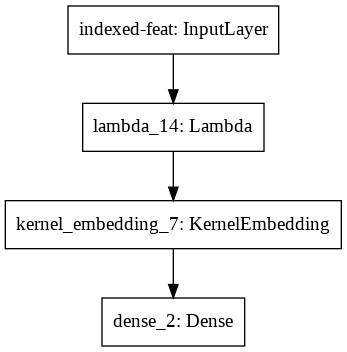

In [76]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [74]:
# https://stackoverflow.com/questions/58772846/custom-tensorflow-keras-optimizer
model.fit(utils.add_index(x_train_eigenpro), y_train)

NotImplementedError: ignored

In [72]:
model.fit(utils.add_index(x_train_eigenpro), y_train,
          batch_size=256, epochs=10, verbose=0,
          validation_data=(utils.add_index(x_test_eigenpro), y_test))

TypeError: ignored

### Define, train, and evaluate a linear model

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5)
model.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.7022 - accuracy: 0.8227
Epoch 2/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3117 - accuracy: 0.9144
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2854 - accuracy: 0.9202
Epoch 4/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2699 - accuracy: 0.9241
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.2640 - accuracy: 0.9264


[0.2639727294445038, 0.9264000058174133]

In [ ]:
print(tf.math.confusion_matrix(y_test, tf.argmax(model.predict(x_test), axis=1)))

tf.Tensor(
[[ 964    0    2    2    0    4    5    2    1    0]
 [   0 1111    3    2    0    1    4    2   12    0]
 [   7    9  929   14    8    5   12   10   35    3]
 [   4    0   19  919    0   25    2   12   21    8]
 [   2    1    6    1  919    0    8    3   10   32]
 [  10    3    5   29   11  778   15    6   28    7]
 [  14    3    6    1    7   14  909    2    2    0]
 [   1    6   23    5    8    0    0  947    2   36]
 [   9    7    7   23    9   26    9   11  864    9]
 [  11    7    1   11   30    8    0   17    4  920]], shape=(10, 10), dtype=int32)


In [ ]:
# A plotting function you can reuse
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

Epoch 1/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7193 - accuracy: 0.8155 - val_loss: 0.3074 - val_accuracy: 0.9144
Epoch 2/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3102 - accuracy: 0.9130 - val_loss: 0.2823 - val_accuracy: 0.9202
Epoch 3/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2818 - accuracy: 0.9182 - val_loss: 0.2770 - val_accuracy: 0.9227
Epoch 4/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2712 - accuracy: 0.9241 - val_loss: 0.2697 - val_accuracy: 0.9249
Epoch 5/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2629 - accuracy: 0.9264 - val_loss: 0.2695 - val_accuracy: 0.9254
Epoch 6/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2615 - accuracy: 0.9279 - val_loss: 0.2674 - val_accuracy: 0.9269
Epoch 7/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2563 - accuracy: 0.9292 - val_loss: 0.2662 -

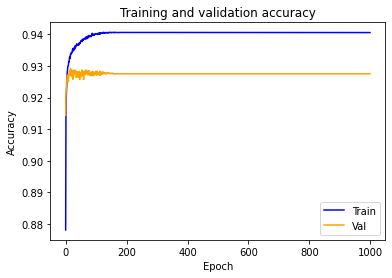

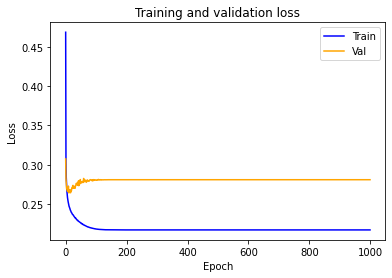

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# use tf learning rate scheduler
def scheduler(epoch, lr):
    return lr * (1-0.5*(epoch/1000))

history = model.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model.predict(x_test), axis=1)))


Epoch 1/2000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.7277 - accuracy: 0.8112 - val_loss: 0.3102 - val_accuracy: 0.9129
Epoch 2/2000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3097 - accuracy: 0.9148 - val_loss: 0.2862 - val_accuracy: 0.9197
Epoch 3/2000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2824 - accuracy: 0.9203 - val_loss: 0.2751 - val_accuracy: 0.9238
Epoch 4/2000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2759 - accuracy: 0.9223 - val_loss: 0.2710 - val_accuracy: 0.9241
Epoch 5/2000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2666 - accuracy: 0.9253 - val_loss: 0.2673 - val_accuracy: 0.9258
Epoch 6/2000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2663 - accuracy: 0.9268 - val_loss: 0.2691 - val_accuracy: 0.9256
Epoch 7/2000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2587 - accuracy: 0.9271 - val_loss: 0.2668 -

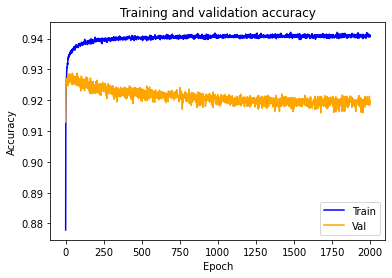

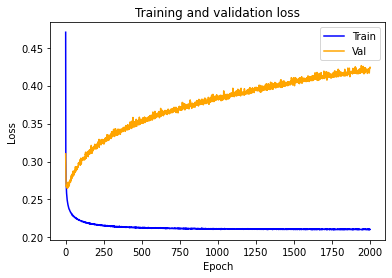

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=2000, validation_data=(x_test, y_test))
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model.predict(x_test), axis=1)))

In [5]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='sgd',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=3000, validation_data=(x_test, y_test))
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model.predict(x_test), axis=1)))

Streaming output truncated to the last 5000 lines.
Epoch 501/3000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2394 - accuracy: 0.9346 - val_loss: 0.2657 - val_accuracy: 0.9253
Epoch 502/3000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2387 - accuracy: 0.9337 - val_loss: 0.2661 - val_accuracy: 0.9267
Epoch 503/3000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2333 - accuracy: 0.9368 - val_loss: 0.2659 - val_accuracy: 0.9264
Epoch 504/3000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2386 - accuracy: 0.9359 - val_loss: 0.2657 - val_accuracy: 0.9258
Epoch 505/3000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2320 - accuracy: 0.9356 - val_loss: 0.2655 - val_accuracy: 0.9257
Epoch 506/3000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2349 - accuracy: 0.9352 - val_loss: 0.2664 - val_accuracy: 0.9263
Epoch 507/3000
1875/1875 [==============================] - 3

NameError: ignored

In [ ]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10, activation='relu')
])

model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=2000, validation_data=(x_test, y_test))
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model.predict(x_test), axis=1)))

### 1b: Implement a neural network 


Modify the code below to create a neural network (with a single hidden layer). Add a Dense layer with 128 units and ReLU activation. 

Streaming output truncated to the last 5000 lines.
1875/1875 [==============================] - 4s 2ms/step - loss: 7.8422e-10 - accuracy: 1.0000 - val_loss: 0.3518 - val_accuracy: 0.9809
Epoch 507/3000
1875/1875 [==============================] - 4s 2ms/step - loss: 8.3762e-10 - accuracy: 1.0000 - val_loss: 0.3518 - val_accuracy: 0.9804
Epoch 508/3000
1875/1875 [==============================] - 4s 2ms/step - loss: 8.3957e-10 - accuracy: 1.0000 - val_loss: 0.3531 - val_accuracy: 0.9807
Epoch 509/3000
1875/1875 [==============================] - 4s 2ms/step - loss: 7.8823e-10 - accuracy: 1.0000 - val_loss: 0.3526 - val_accuracy: 0.9808
Epoch 510/3000
1875/1875 [==============================] - 4s 2ms/step - loss: 8.4807e-10 - accuracy: 1.0000 - val_loss: 0.3535 - val_accuracy: 0.9805
Epoch 511/3000
1875/1875 [==============================] - 4s 2ms/step - loss: 9.4989e-10 - accuracy: 1.0000 - val_loss: 0.3530 - val_accuracy: 0.9808
Epoch 512/3000
1875/1875 [==========================

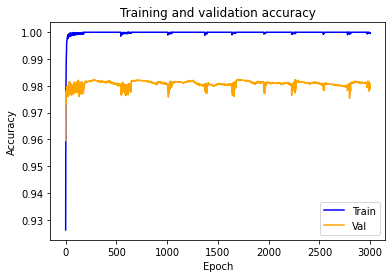

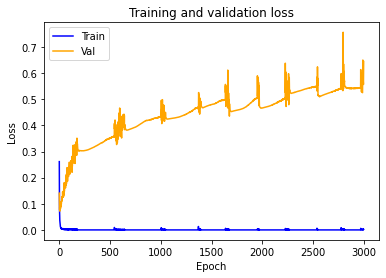

In [ ]:
model_deep = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model_deep.summary())

model_deep.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_deep.fit(x_train, y_train, epochs=3000, validation_data=(x_test, y_test))
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_deep.predict(x_test), axis=1)))

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 55.6801 - accuracy: 0.5274 - val_loss: 8.5369 - val_accuracy: 0.8510
Epoch 2/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 7.5849 - accuracy: 0.8595 - val_loss: 5.6538 - val_accuracy: 0.8870
Epoch 3/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 4.

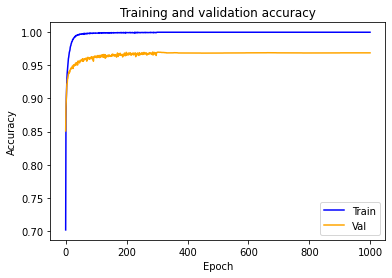

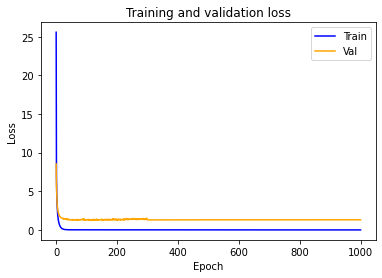

In [ ]:
# this initializer uses sqrt(2) as stddev, much higher than default, should trigger lazy training
initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=1.414, seed=20000)
# default initializer is glorot initialization: truncated normal distribution centered on 0 with 
# stddev = sqrt(2 / (fan_in + fan_out)), variance is 2 / (fan_in + fan_out) = 0.00252
# fan-in=784 fan-out=10 for single hidden layer (stddet = 0.05, var=0.00252)
model_deep = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu', kernel_initializer = initializer),
  tf.keras.layers.Dense(10, activation='softmax', kernel_initializer = initializer)
])

print(model_deep.summary())

model_deep.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model_deep.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test))
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_deep.predict(x_test), axis=1)))

In [ ]:
# Conclusion: model getting stuck at a minima and not moving over many epochs is caused by the learning rate scheduler
# do not use learning rate scheduler (or at least be careful with them in future experiments)

# with learning rate scheduler
model_deep = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model_deep.summary())

model_deep.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# use tf learning rate scheduler
def scheduler(epoch, lr):
    return lr * (1-0.5*(epoch/1000))

history = model_deep.fit(x_train, y_train, epochs=1000, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
   
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model_deep.predict(x_test), axis=1)))


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4246 - accuracy: 0.8795 - val_loss: 0.1360 - val_accuracy: 0.9582
Epoch 2/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1191 - accuracy: 0.9653 - val_loss: 0.1031 - val_accuracy: 0.9688
Epoch 3/1000
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0

KeyboardInterrupt: ignored

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              803840    
_________________________________________________________________
dense_15 (Dense)             (None, 10)                10250     
Total params: 814,090
Trainable params: 814,090
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3115 - accuracy: 0.9054 - val_loss: 0.0965 - val_accuracy: 0.9701
Epoch 2/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0756 - accuracy: 0.9774 - val_loss: 0.0803 - val_accuracy: 0.9747
Epoch 3/100
1875/1875 [==============================] - 4s 2ms/step - loss: 0.047

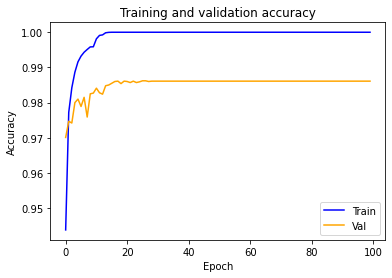

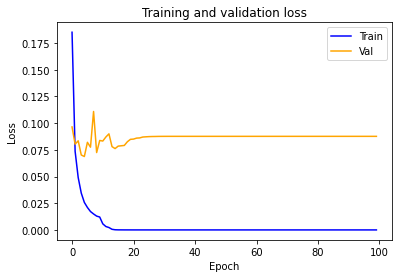

In [ ]:
# wider with learning rate scheduler
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model3.summary())

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.8**(epoch//10))

history = model3.fit(x_train, y_train, epochs=100, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 2048)              1607680   
_________________________________________________________________
dense_17 (Dense)             (None, 10)                20490     
Total params: 1,628,170
Trainable params: 1,628,170
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2948 - accuracy: 0.9105 - val_loss: 0.0898 - val_accuracy: 0.9704
Epoch 2/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0724 - accuracy: 0.9776 - val_loss: 0.0784 - val_accuracy: 0.9738
Epoch 3/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.04

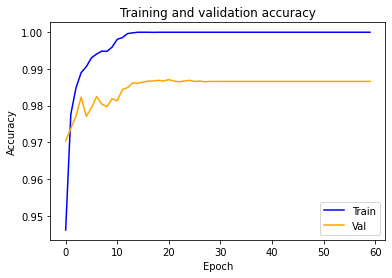

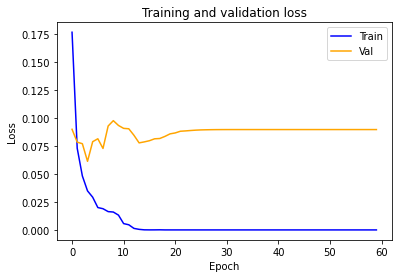

In [ ]:
# wider with learning rate scheduler
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(2048, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model3.summary())

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.8**(epoch//10))

history = model3.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_13 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 5120)              4019200   
_________________________________________________________________
dense_19 (Dense)             (None, 10)                51210     
Total params: 4,070,410
Trainable params: 4,070,410
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2823 - accuracy: 0.9133 - val_loss: 0.0816 - val_accuracy: 0.9747
Epoch 2/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0777 - accuracy: 0.9747 - val_loss: 0.0721 - val_accuracy: 0.9770
Epoch 3/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.04

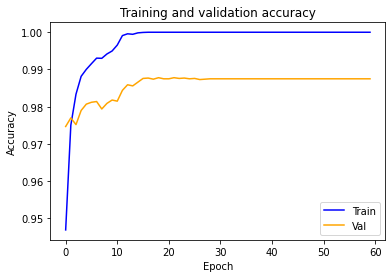

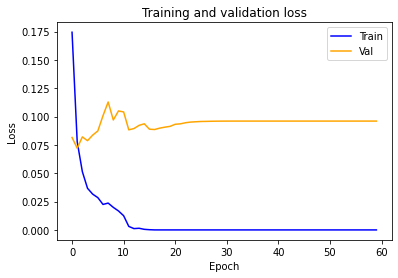

In [ ]:
# wider with learning rate scheduler
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(5120, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model3.summary())

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.8**(epoch//10))

history = model3.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_14 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10240)             8038400   
_________________________________________________________________
dense_21 (Dense)             (None, 10)                102410    
Total params: 8,140,810
Trainable params: 8,140,810
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2812 - accuracy: 0.9133 - val_loss: 0.1227 - val_accuracy: 0.9645
Epoch 2/60
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0785 - accuracy: 0.9760 - val_loss: 0.0995 - val_accuracy: 0.9692
Epoch 3/60
1875/1875 [==============================] - 6s 3ms/step - loss: 0.05

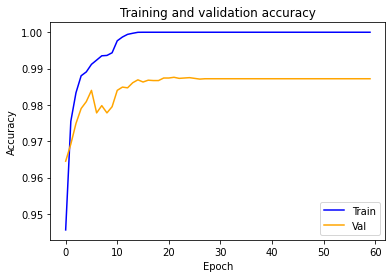

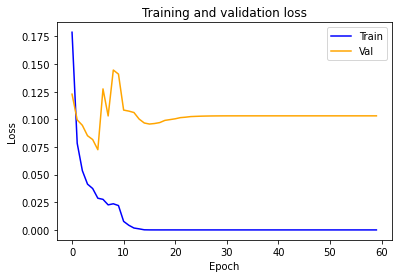

In [ ]:
# wider with learning rate scheduler
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10240, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model3.summary())

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.8**(epoch//10))

history = model3.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 10240)             8038400   
_________________________________________________________________
dense_23 (Dense)             (None, 10)                102410    
Total params: 8,140,810
Trainable params: 8,140,810
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2863 - accuracy: 0.9117 - val_loss: 0.1009 - val_accuracy: 0.9694
Epoch 2/60
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0783 - accuracy: 0.9765 - val_loss: 0.0966 - val_accuracy: 0.9711
Epoch 3/60
1875/1875 [==============================] - 6s 3ms/step - loss: 0.05

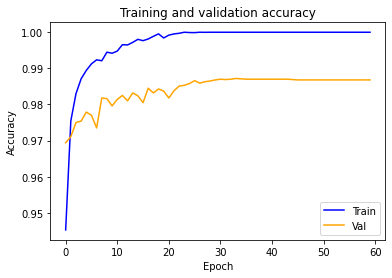

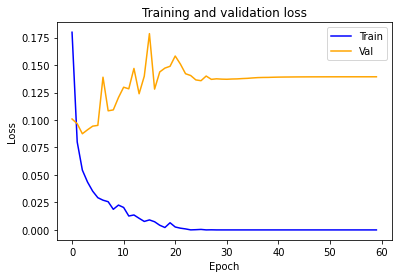

In [ ]:
# wider with gentler learning rate scheduler
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10240, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model3.summary())

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.95**(epoch//10))

history = model3.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_16 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 10240)             8038400   
_________________________________________________________________
dense_25 (Dense)             (None, 10)                102410    
Total params: 8,140,810
Trainable params: 8,140,810
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2872 - accuracy: 0.9120 - val_loss: 0.1339 - val_accuracy: 0.9581
Epoch 2/60
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0791 - accuracy: 0.9754 - val_loss: 0.0760 - val_accuracy: 0.9759
Epoch 3/60
1875/1875 [==============================] - 6s 3ms/step - loss: 0.04

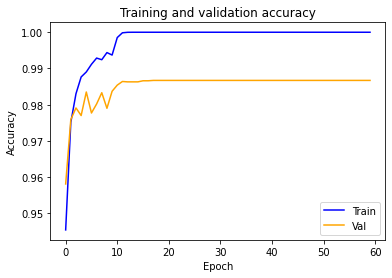

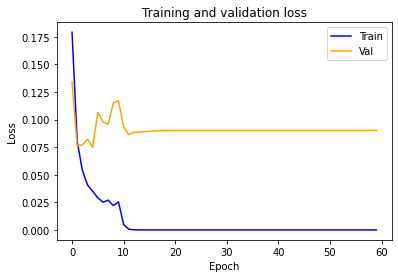

In [ ]:
# wider with stricter learning rate scheduler
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(10240, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model3.summary())

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.5**(epoch//10))

history = model3.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 102400)            80384000  
_________________________________________________________________
dense_27 (Dense)             (None, 10)                1024010   
Total params: 81,408,010
Trainable params: 81,408,010
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
1875/1875 [==============================] - 34s 18ms/step - loss: 0.3416 - accuracy: 0.9023 - val_loss: 0.1074 - val_accuracy: 0.9696
Epoch 2/60
1875/1875 [==============================] - 34s 18ms/step - loss: 0.0927 - accuracy: 0.9725 - val_loss: 0.1062 - val_accuracy: 0.9720
Epoch 3/60
1875/1875 [==============================] - 34s 18ms/step - lo

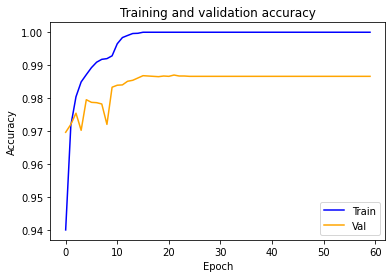

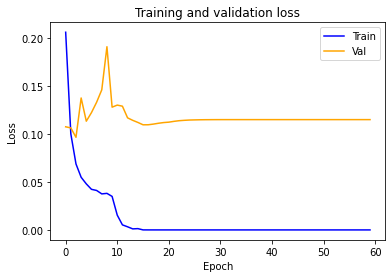

In [ ]:
# much wider with learning rate scheduler
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(102400, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model3.summary())

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.8**(epoch//10))

history = model3.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 202400)            158884000 
_________________________________________________________________
dense_5 (Dense)              (None, 10)                2024010   
Total params: 160,908,010
Trainable params: 160,908,010
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
1875/1875 [==============================] - 156s 82ms/step - loss: 0.3992 - accuracy: 0.9009 - val_loss: 0.1185 - val_accuracy: 0.9642
Epoch 2/30
1875/1875 [==============================] - 153s 82ms/step - loss: 0.0972 - accuracy: 0.9730 - val_loss: 0.1104 - val_accuracy: 0.9703
Epoch 3/30
1875/1875 [==============================] - 155s 83ms/step 

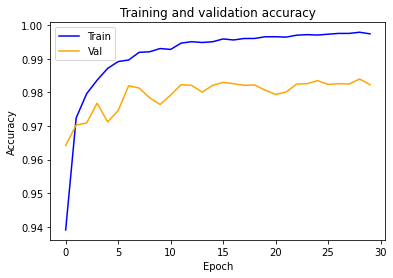

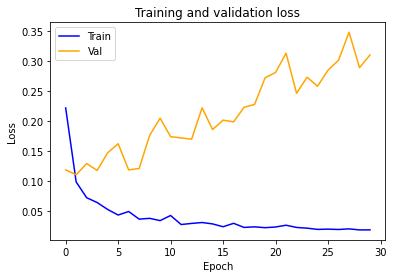

In [ ]:
# much much wider with no learning rate scheduler
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(202400, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model3.summary())

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.8**(epoch//10))

history = model3.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test))
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))

In [ ]:
# much much wider with learning rate scheduler
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(202400, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

print(model3.summary())

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.98**epoch)

history = model3.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 202400)            158884000 
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2024010   
Total params: 160,908,010
Trainable params: 160,908,010
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/60
1875/1875 [==============================] - 35s 17ms/step - loss: 0.4015 - accuracy: 0.8999 - val_loss: 0.1174 - val_accuracy: 0.9665
Epoch 2/60
1875/1875 [==============================] - 32s 17ms/step - loss: 0.0947 - accuracy: 0.9714 - val_loss: 0.0962 - val_accuracy: 0.9742
Epoch 3/60
1875/1875 [==============================] - 32s 17ms/step - los

NameError: ignored

Epoch 1/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.4089 - accuracy: 0.8779 - val_loss: 0.1294 - val_accuracy: 0.9594
Epoch 2/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1044 - accuracy: 0.9686 - val_loss: 0.1017 - val_accuracy: 0.9694
Epoch 3/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0693 - accuracy: 0.9779 - val_loss: 0.1182 - val_accuracy: 0.9647
Epoch 4/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0530 - accuracy: 0.9837 - val_loss: 0.0868 - val_accuracy: 0.9731
Epoch 5/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0393 - accuracy: 0.9879 - val_loss: 0.0915 - val_accuracy: 0.9740
Epoch 6/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0371 - accuracy: 0.9884 - val_loss: 0.1134 - val_accuracy: 0.9723
Epoch 7/60
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0308 - accuracy: 0.9895 - val_loss: 0.0867 - val_accuracy:

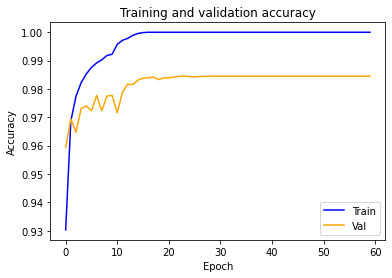

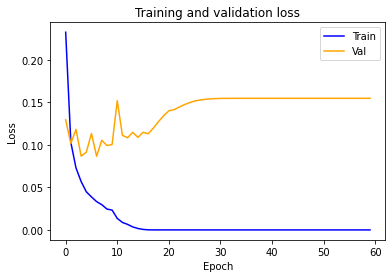

In [ ]:
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def scheduler(epoch, lr):
    return lr * (0.8**(epoch//10))

history = model3.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), callbacks = [tf.keras.callbacks.LearningRateScheduler(scheduler)])
  
plot(history)
print(tf.math.confusion_matrix(y_test, tf.argmax(model3.predict(x_test), axis=1)))